## ***Spaceship Titanic***

<p align="center">
  <img src="midjourney_1.png" alt="midjourney_1.png"><br>
  Image by Midjourney, prompt by me
</p>



*Hi there stranger, welcome to this notebook on the Kaggle Spaceship Titanic Competition* 👩‍🚀🚀👽<br><br>
This notebook is a fork of the [Titanic - A Complete Guide](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide) by [Samuel Cortinhas](https://www.kaggle.com/samuelcortinhas). My intention with this notebook is not to get a higher score than the original score. Instead, I will be focusing on the code. I aim to make the code more efficient, faster, cleaner, and DRY (don't repeat yourself), while also making it more fun and interesting to follow. I will keep Samuel's original structure from his notebook, but I will rewrite all the code (except for a few plots), leaving only the original markdown cells.
<br>


While I was looking at the original notebook, I found the EDA and data processing to be very interesting, with many clever ways of handling the data. But I also found the code to be very inefficient and redundant, and thus I started to rewrite it. The reason that I chose to keep the exact structure of Samuel's notebook is that: 1) I wanted to get the exact same score to confirm that my new, rewritten code was the same as the original, and 2) The original notebook is in version 47, therefore it's already highly optimized. <br><br>


If I compare the runtime of my rewritten notebook to the original (skipping the PCA part and only training the models that will be used in the final submission to keep our notebooks identical), I get the following results: EDA and feature engineering: 32 seconds for mine and 109 seconds for the original. Total runtime: 4 minutes and 21 seconds for mine and 5 minutes and 39 seconds for the original (3.5 minutes is for training the CatBoost model). So as you can see, my notebook is **2.5 times faster than the original** (excluding training time for CatBoost), and the EDA and feature engineering are **3.5 times faster**.
<br><br> In my next notebook, I will also try to improve the score by optimizing the hyperparameters of the models using the Optuna library and see if I can beat the original score.
<br><br><br>
So here we go, let's get started! 🚀

## ***Introduction***

Welcome to this comprehensive guide on **binary classification** with the **Spaceship Titanic** dataset. The objective is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with a spacetime anomaly.

For the modeling part, i 

*We will cover:*
* Exploratory Data Analysis
* Feature Engineering
* Data Cleaning
* Encoding, Scaling and Preprocessing
* Training Machine Learning Models
* Cross Validation and Ensembling Predictions

## ***Libraries***

In [333]:
%%capture
!pip install jupyter_black
!pip install lightgbm
!pip install catboost

In [354]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

In [295]:
import jupyter_black

jupyter_black.load()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.4)


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
)

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


from time import time
import warnings

warnings.filterwarnings("ignore")

pd.options.display.max_columns = None

## ***Data***

**Load data**

In [296]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Training shape:", train.shape)
print("Testing shape:", test.shape)
train.head()

Training shape: (8693, 14)
Testing shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


*Feature descriptions:*
> * **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
> * **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
> * **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
> * **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
> * **Destination** - The planet the passenger will be debarking to.
> * **Age** - The age of the passenger.
> * **VIP** - Whether the passenger has paid for special VIP service during the voyage.
> * **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
> * **Name** - The first and last names of the passenger.
> * **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

**Missing values, cardinality & data type**

In [350]:
pd.DataFrame(
    {
        "train_na": train.isna().sum(),
        "test_na": test.isna().sum(),
        "nunique": train.nunique(),
        "dtypes": train.dtypes,
    }
)

,train_na,test_na,nunique,dtypes
Age,179,91.0,80,float64
Cabin,199,100.0,6560,object
CryoSleep,217,93.0,2,object
Destination,182,92.0,3,object
FoodCourt,183,106.0,1507,float64
HomePlanet,201,87.0,3,object
Name,200,94.0,8473,object
PassengerId,0,0.0,8693,object
RoomService,181,82.0,1273,float64
ShoppingMall,208,98.0,1115,float64


Almost every feature has missing values! How we deal with these values will be very important. <br>
There are 6 continuous features, 4 categorical features (excluding the target) and 3 descriptive/qualitative features

**Duplicates**

In [353]:
print(f"Duplicates in train set: {train.duplicated().sum()}")
print(f"Duplicates in test set: {test.duplicated().sum()}")

Duplicates in train set: 0
Duplicates in test set: 0


****

## ***EDA***

Let us explore the dataset to gain insights. 

**Target distribution**

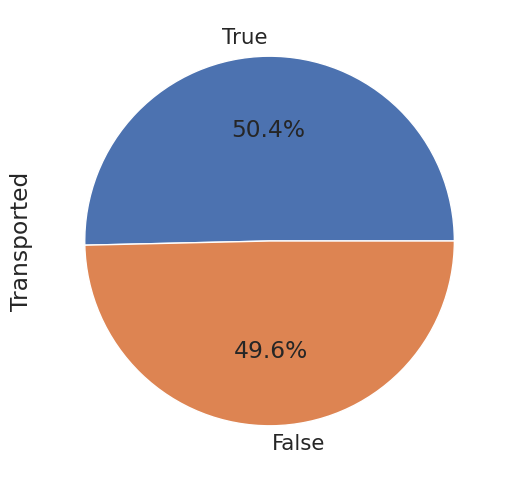

In [318]:
plt.figure(figsize=(6, 6))
train["Transported"].value_counts().plot.pie(autopct="%1.1f%%", y="count");

The target is highly balanced, so we luckily don't have to consider techniques like under/over-sampling.

**Correlation**

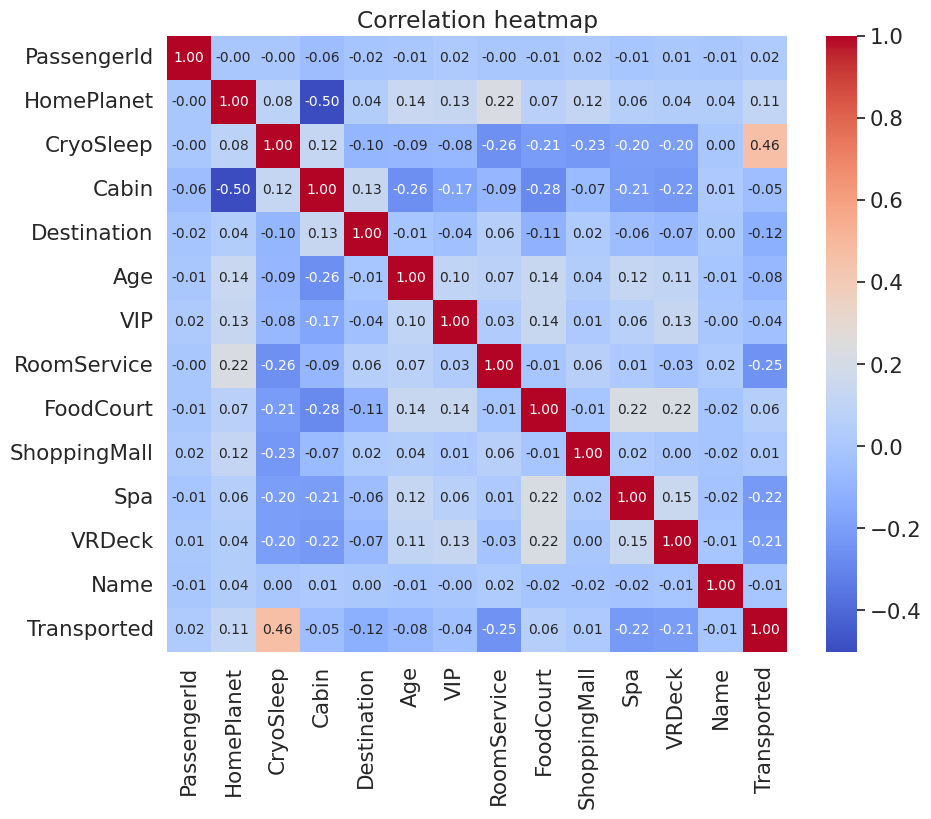

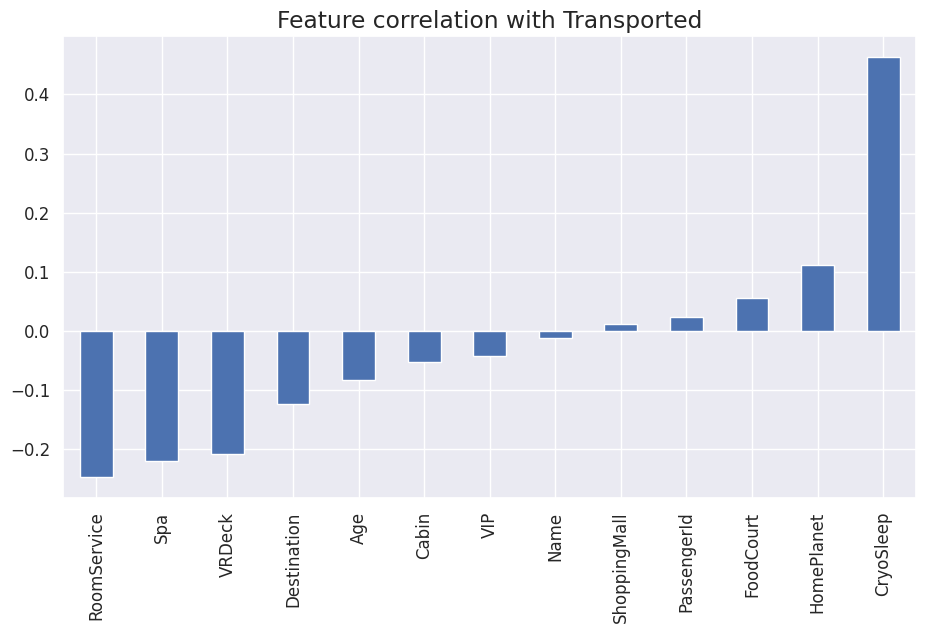

In [340]:
def clean_and_visualize():
    df = train.copy()
    df = df.dropna()

    for col in df.select_dtypes(exclude=np.number).columns:
        df[col] = pd.Categorical(df[col]).codes

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df.corr(), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10}
    ).set_title("Correlation heatmap")
    plt.show()
    
    print()
    df.drop(["Transported"], axis=1).corrwith(df.Transported).sort_values().plot(
        kind="bar", fontsize=12, figsize=(11, 6)
    ).set_title("Feature correlation with Transported")


clean_and_visualize()

CyroSleep have the highest correlation to Transported at 0.46, the remaining features have weaker correlation coefficients between -0.25 and 0.1. Maybe there are some hidden relationships between the features that we can discover?

**Continuous features**

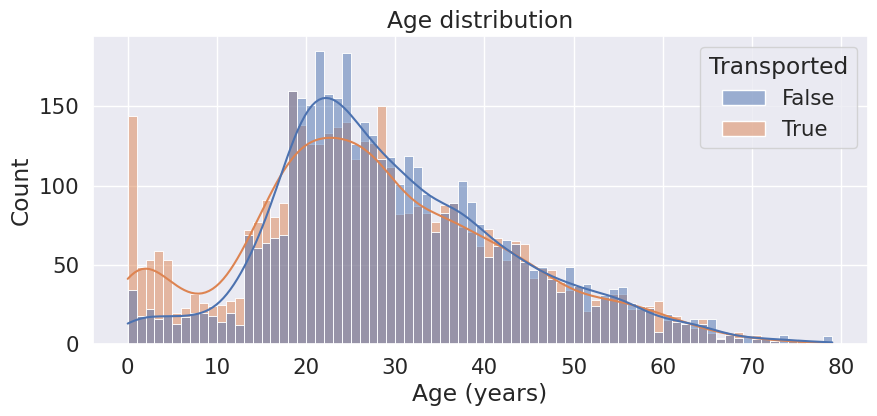

In [355]:
plt.figure(figsize=(10, 4))
sns.histplot(data=train, x="Age", hue="Transported", binwidth=1, kde=True)

plt.title("Age distribution")
plt.xlabel("Age (years)");

*Notes:*
* 0-18 year olds were **more** likely to be transported than not.
* 18-25 year olds were **less** likely to be transported than not.
* Over 25 year olds were about **equally** likely to be transported than not.

*Insight:*
* Create a new feature that indicates whether the passanger is a child, adolescent or adult.

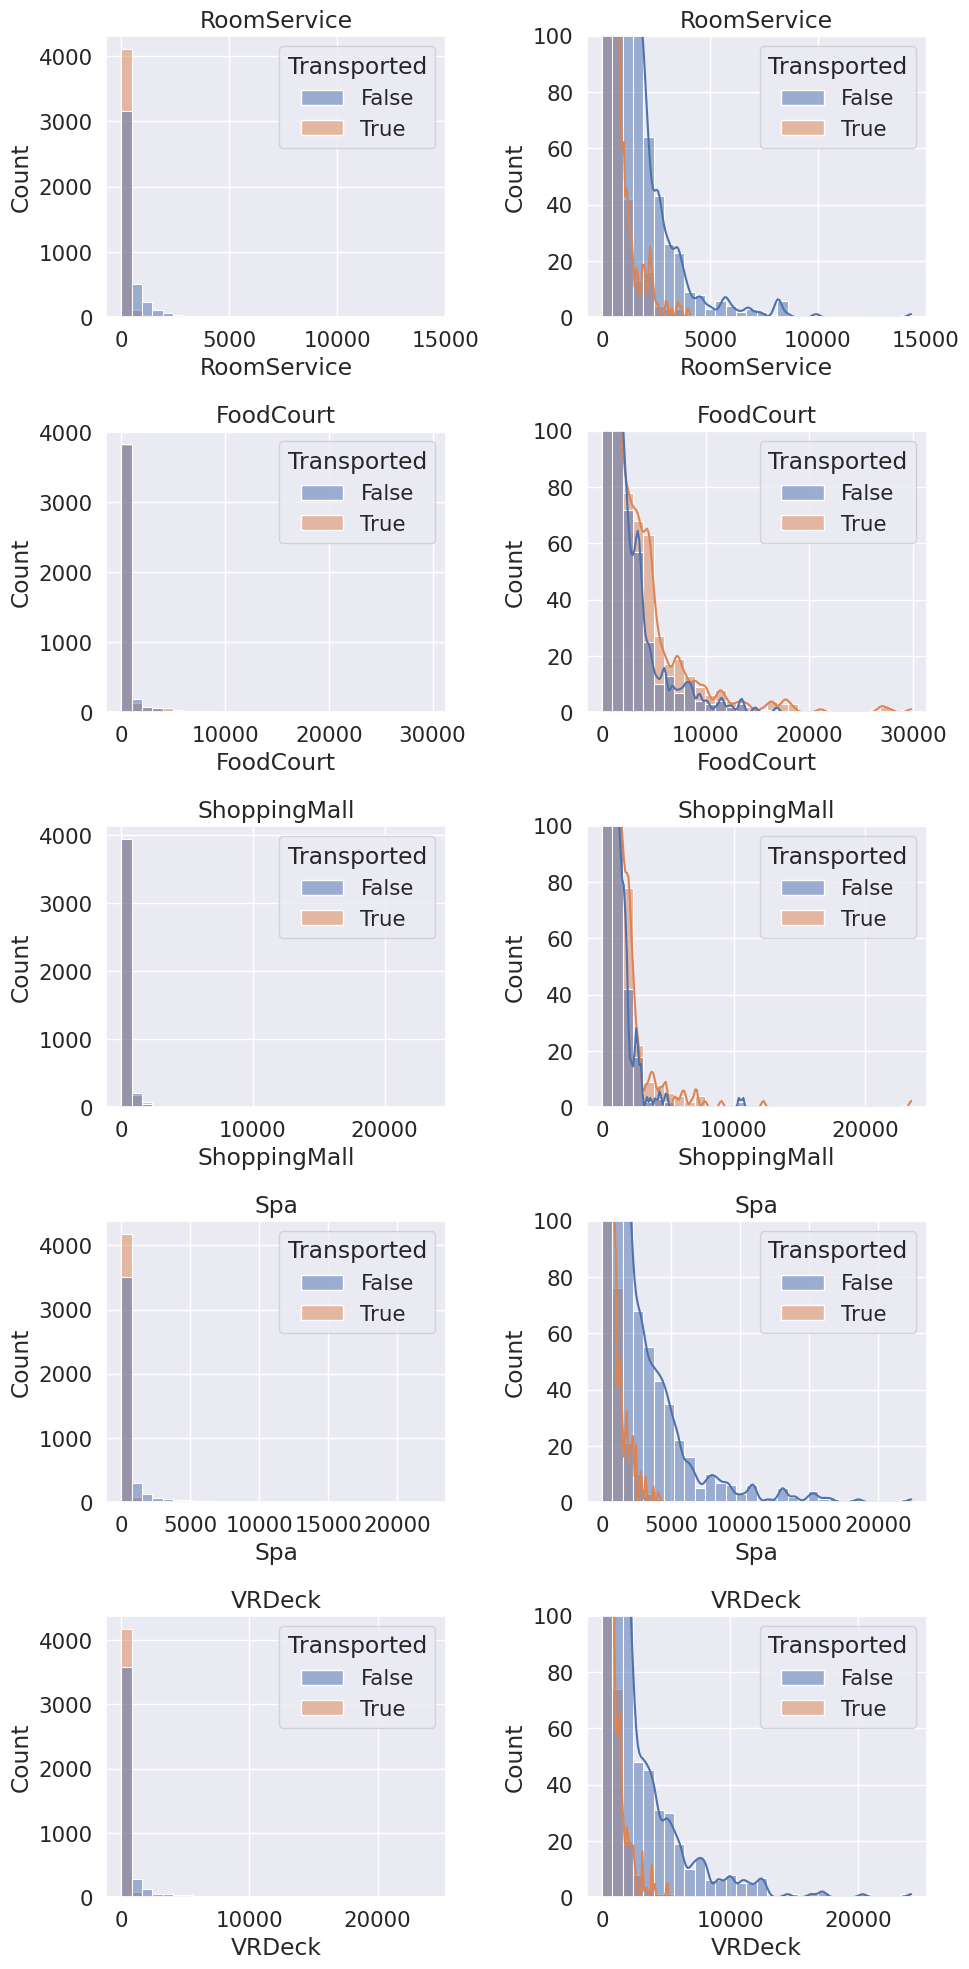

In [ ]:
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

exp_feats = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

fig = plt.figure(figsize=(10, 20))
for i, var_name in enumerate(exp_feats):
    ax = fig.add_subplot(5, 2, 2 * i + 1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue="Transported")
    ax.set_title(var_name)

    ax = fig.add_subplot(5, 2, 2 * i + 2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue="Transported")
    plt.ylim([0, 100])
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

*Notes:*
* Most people don't spend any money (as we can see on the left).
* The distribution of spending decays exponentially (as we can see on the right).
* There are a small number of outliers.
* People who were transported tended to spend less.
* RoomService, Spa and VRDeck have different distributions to FoodCourt and ShoppingMall - we can think of this as luxury vs essential amenities. 

*Insight:*
* Create a new feature that tracks the total expenditure across all 5 amenities.
* Create a binary feature to indicate if the person has not spent anything. (i.e. total expenditure is 0).
* Take the log transform to reduce skew.

**Categorical features**

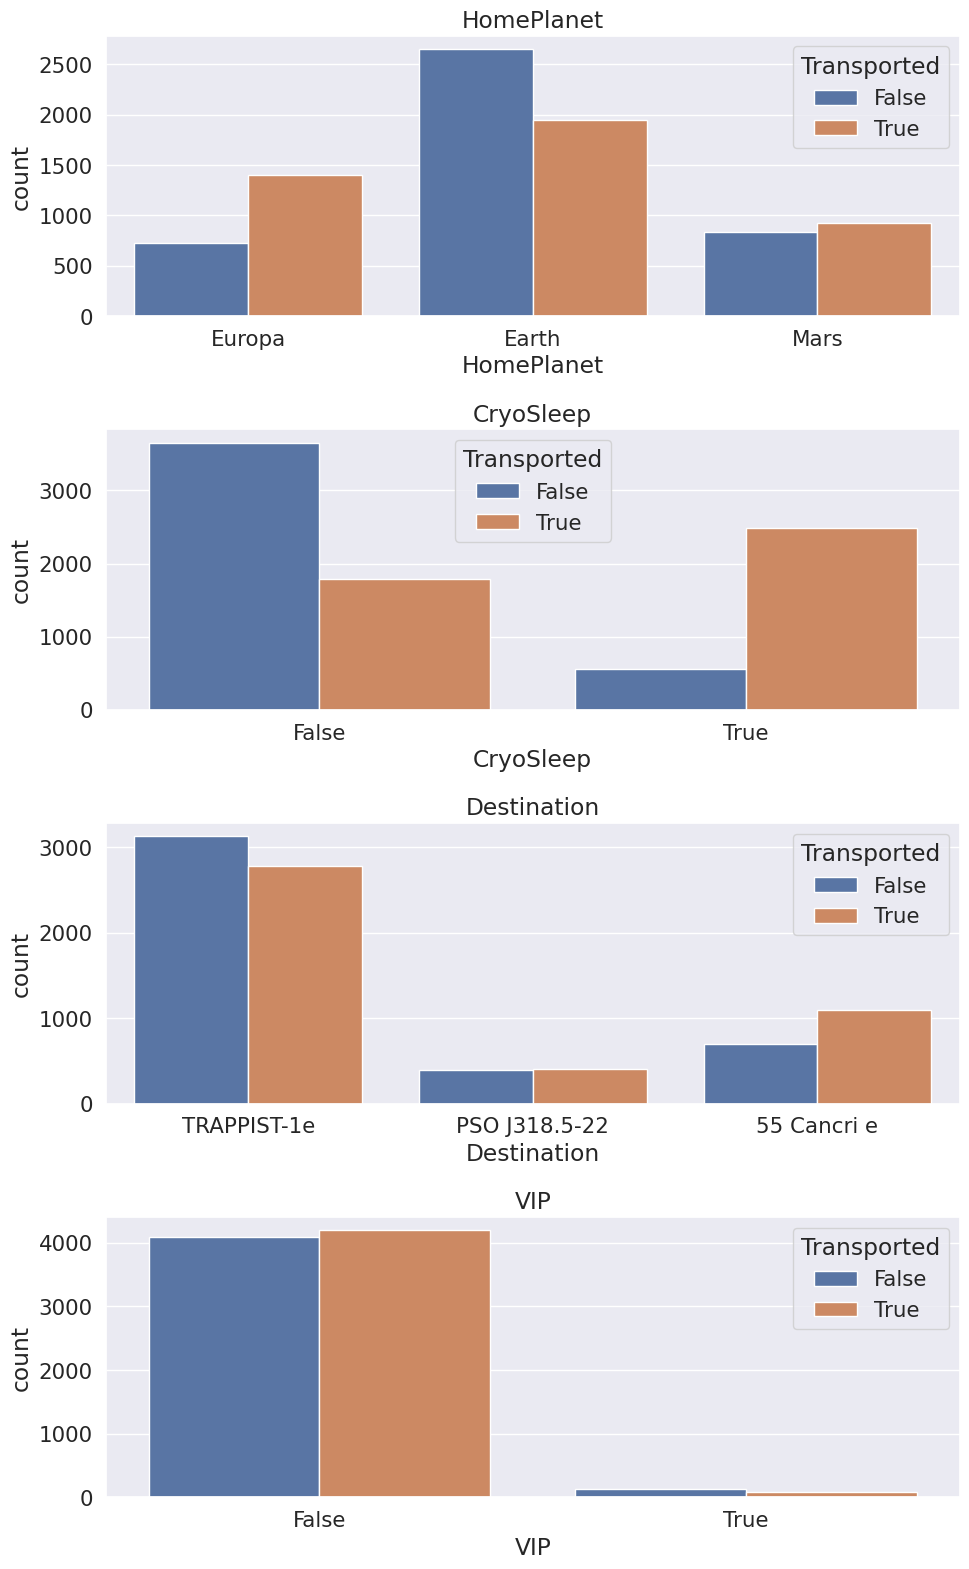

In [ ]:
cat_feats = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

fig = plt.figure(figsize=(10, 16))
for i, var_name in enumerate(cat_feats):
    ax = fig.add_subplot(4, 1, i + 1)
    sns.countplot(data=train, x=var_name, axes=ax, hue="Transported")
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

*Notes:*
* VIP does not appear to be a useful feature; the target split is more or less equal. 
* CryoSleep appears the be a very useful feature in contrast.

*Insights:*
* We might consider dropping the VIP column to prevent overfitting.

**Qualitative features**

We can't plot this data (yet). We need to transform it into more useful features.

In [ ]:
qual_feats = ["PassengerId", "Cabin", "Name"]

train[qual_feats].head(2)

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines


*Notes:*
* PassengerId takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
* Cabin takes the form deck/num/side, where side can be either P for Port or S for Starboard.

*Insights:*
* We can extract the group and group size from the PassengerId feature. 
* We can extract the deck, number and side from the cabin feature. 
* We could extract the surname from the name feature to identify families. 

## ***Feature engineering***

**Age status**

Bin age feature into groups. This will be helpful for filling missing values like expenditure according to age.

In [ ]:
age_bins = [-1, 12, 17, 25, 30, 50, np.inf]
age_titles = ["Age_0-12", "Age_13-17", "Age_18-25", "Age_26-30", "Age_31-50", "Age_51+"]

for df in train, test:
    df["AgeGroup"] = pd.cut(df["Age"], age_bins, labels=age_titles)

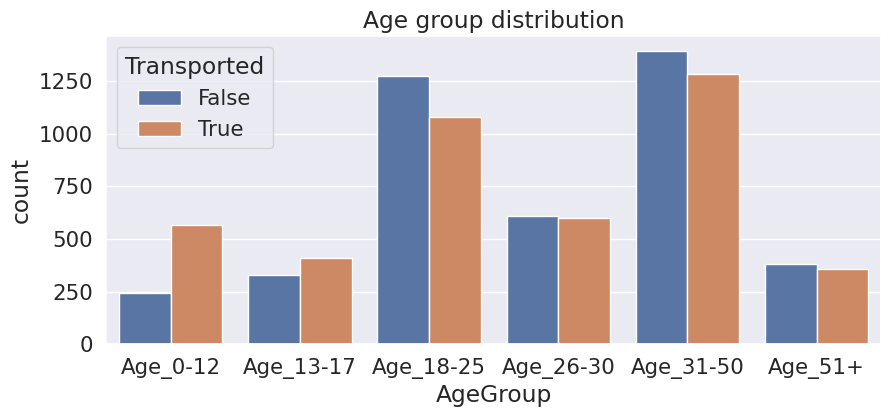

In [ ]:
plt.figure(figsize=(10, 4))
g = sns.countplot(
    data=train,
    x="AgeGroup",
    hue="Transported",
    order=age_titles,
)
plt.title("Age group distribution");

**Expenditure**

Calculate total expenditure and identify passengers with no expenditure.

In [ ]:
for df in train, test:
    df["Expenditure"] = df[exp_feats].sum(axis=1)
    df["NoSpending"] = (df["Expenditure"] == 0).astype(int)

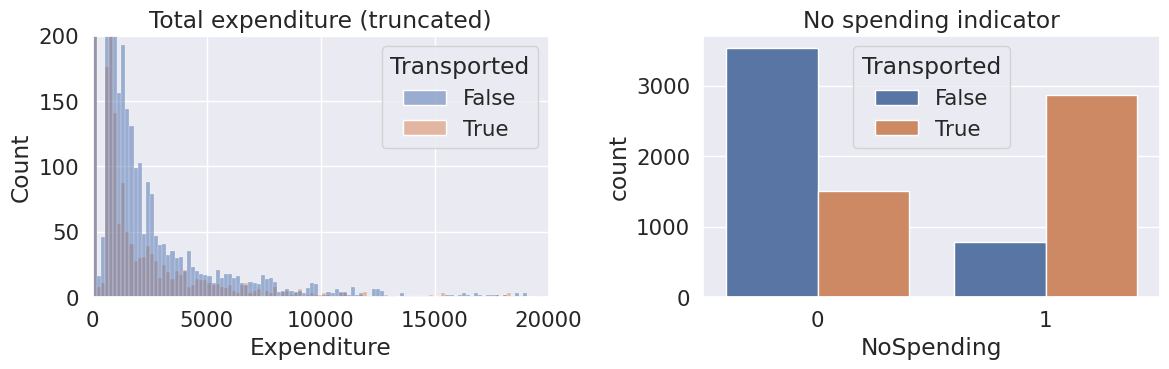

In [ ]:
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=train, x="Expenditure", hue="Transported", bins=200)
plt.title("Total expenditure (truncated)")
plt.ylim([0, 200])
plt.xlim([0, 20000])

plt.subplot(1, 2, 2)
sns.countplot(data=train, x="NoSpending", hue="Transported")
plt.title("No spending indicator")
fig.tight_layout()

**Passenger group**

Extract passenger group and group size from PassengerId. PassengerId looks like this xxxx_yy; xxxx = group number, yy = id for that group.

In [ ]:
train["PassengerId"].head(5)

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
Name: PassengerId, dtype: object

Here we can see that group 1, 2 and 4 are solo travelers, while group 3 is a company of 2 people.

Calculate group size from PassengerId. We will use data from both train and test sets to get a more accurate group size.

In [ ]:
f = lambda x: x.split("_")[0]

for df in train, test:
    df["Group"] = df["PassengerId"].apply(f).astype(int)

group_dict = pd.concat([train["Group"], test["Group"]]).value_counts().to_dict()

for df in train, test:
    df["GroupSize"] = df["Group"].map(group_dict)

We can't really use the Group feature in our models because it has too big of a cardinality (6217) and would explode the number of dimensions with one-hot encoding.

The Group size on the other hand should be a useful feature. 

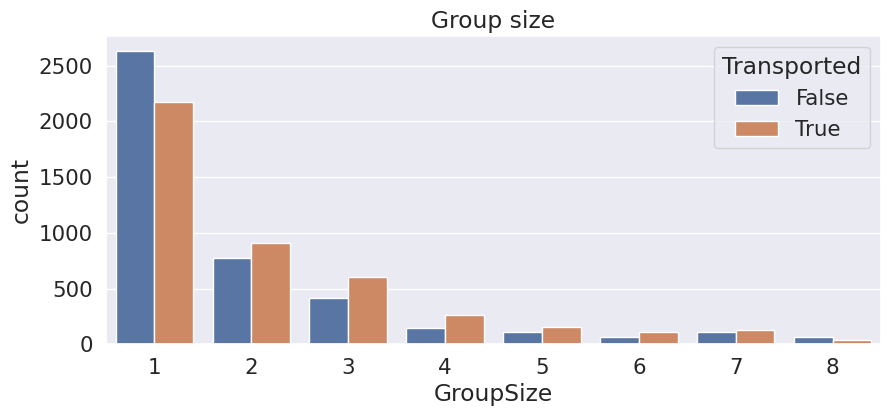

In [ ]:
plt.figure(figsize=(10, 4))
sns.countplot(data=train, x="GroupSize", hue="Transported")
plt.title("Group size")
fig.tight_layout()

In fact, we can compress the feature further by creating a 'Solo' column that tracks whether someone is travelling on their own or not. The figure on the right shows that group size=1 is less likely to be transported than group size>1.

In [ ]:
for df in train, test:
    df["Solo"] = (df["GroupSize"] == 1).astype(int)

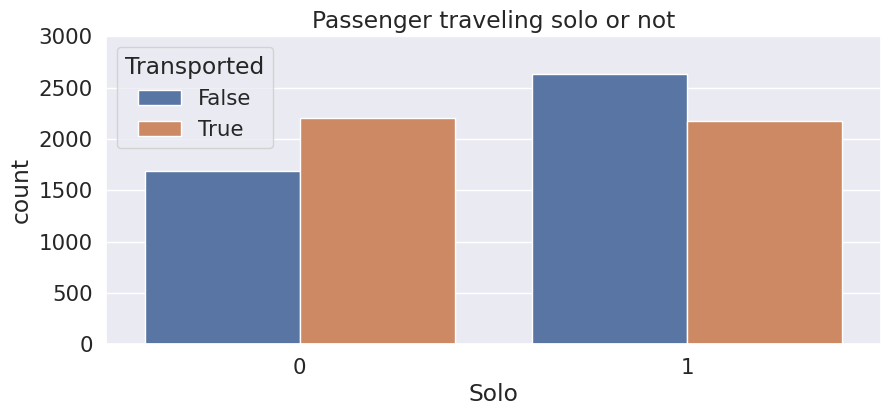

In [ ]:
plt.figure(figsize=(10, 4))
sns.countplot(data=train, x="Solo", hue="Transported")
plt.title("Passenger traveling solo or not")
plt.ylim([0, 3000]);

**Cabin location**

Extract deck, number and side from cabin feature.

In [ ]:
f = lambda x: (x, x, x) if pd.isna(x) else x.split("/")

for df in train, test:
    cabin_split = tuple(df["Cabin"].apply(f))

    df[["CabinDeck", "CabinNumber", "CabinSide"]] = pd.DataFrame(cabin_split)
    df["CabinNumber"] = df["CabinNumber"].astype("Int16")
    df.pop("Cabin")

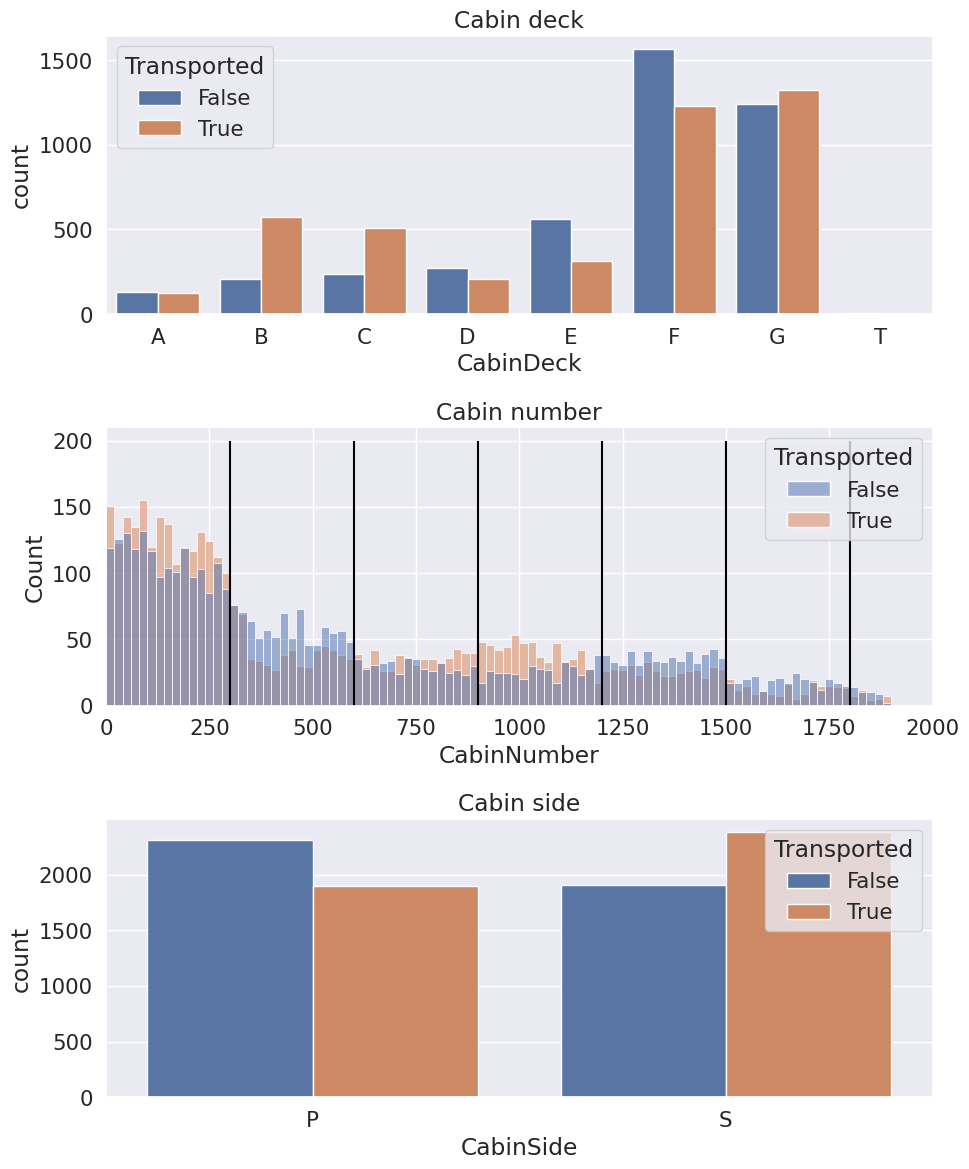

In [ ]:
fig = plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
sns.countplot(
    data=train,
    x="CabinDeck",
    hue="Transported",
    order=(decklist := ["A", "B", "C", "D", "E", "F", "G", "T"]),
)
plt.title("Cabin deck")

plt.subplot(3, 1, 2)
sns.histplot(data=train, x="CabinNumber", hue="Transported", binwidth=20)
for i in range(300, 1900, 300):
    plt.vlines(i, ymin=0, ymax=200, color="black")
plt.title("Cabin number")
plt.xlim([0, 2000])

plt.subplot(3, 1, 3)
sns.countplot(data=train, x="CabinSide", hue="Transported")
plt.title("Cabin side")
fig.tight_layout()

This is interesting! It appears that CabinNumber is grouped into chunks of 300 cabins. This means we can compress this feature into a categorical one, which indicates which chunk each passenger is in.

Other notes: The cabin deck 'T' seems to be an outlier (there are only 5 samples).

In [ ]:
cabin_bins = [-np.inf, 299, 599, 899, 1199, 1499, 1799, np.inf]

region = pd.cut(train["CabinNumber"], cabin_bins, labels=range(1, 8))
train = pd.concat([train, pd.get_dummies(region, prefix="CabinRegion")], axis=1)

region = pd.cut(test["CabinNumber"], cabin_bins, labels=range(1, 8))
test = pd.concat([test, pd.get_dummies(region, prefix="CabinRegion")], axis=1)

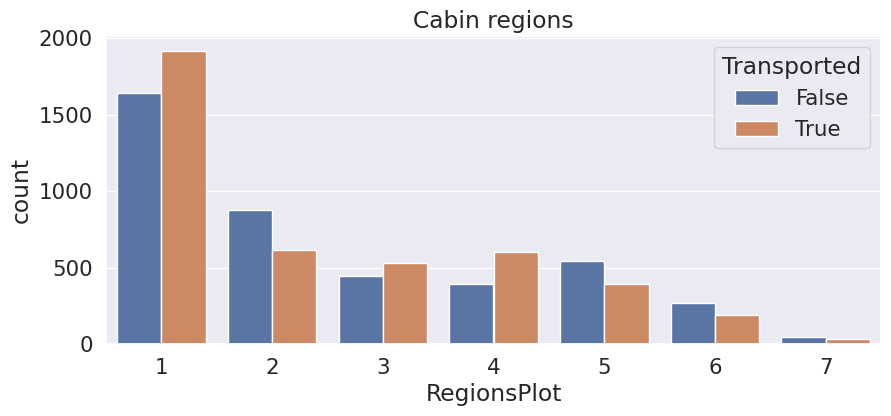

In [ ]:
plt.figure(figsize=(10, 4))
train["RegionsPlot"] = pd.cut(train["CabinNumber"], cabin_bins, labels=range(1, 8))
sns.countplot(data=train, x="RegionsPlot", hue="Transported")
plt.title("Cabin regions")
train.pop("RegionsPlot");

**Last name**

Calculate family size from last name. We will use data from both train and test sets to get a more accurate family size.

In [ ]:
f = lambda x: x if pd.isna(x) else x.split(" ")[1]

for df in train, test:
    df["Surname"] = df["Name"].apply(f)

fam_dict = pd.concat([train["Surname"], test["Surname"]]).value_counts().to_dict()

for df in train, test:
    df["FamilySize"] = df["Surname"].map(fam_dict)
    df.pop("Name");

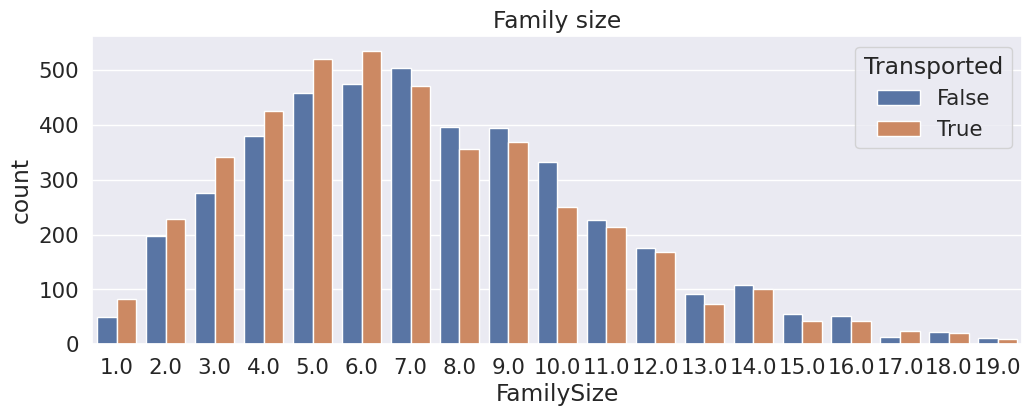

In [ ]:
plt.figure(figsize=(12, 4))
sns.countplot(data=train, x="FamilySize", hue="Transported")
plt.title("Family size");

## ***Missing values***

**Combine train and test**

This will make it easier to fill missing values. We will split it back later.

In [ ]:
X = train.copy()
y = X.pop("Transported").astype(int)

data = pd.concat([X, test], axis=0).reset_index(drop=True)

**Define functions**

*impute_joint_dist:*

Useful when a column shows obvious similarities with another column, for example; if a majority of passengers from homeplanet "mars" have the same destination, then we can use this information to fill missing values on destination for passengers from homeplanet "mars".

In [ ]:
def impute_joint_dist(col, joint, gb):
    df = data.copy()
    d = gb.idxmax(axis=1).to_dict()

    print(f"{col}, missing values before:", df[col].isna().sum())
    df[col] = df[col].fillna(df[joint].map(d))
    print(f"{col}, missing values after:", df[col].isna().sum())
    return df[col]

*impute_transform:*

Utilize pandas groupby and transform to impute the missing values with mode, median, or mean for each of the subgroups created by groupby.

In [ ]:
def impute_transform(col, gb, fill_fn="mode"):
    df = data.copy()

    d = {
        "mode": lambda x: pd.Series.mode(x)[0],
        "median": lambda x: x.median(),
        "mean": lambda x: x.mean(),
    }

    print(f"{col}, missing values before:", df[col].isna().sum())
    c = df.groupby(gb)[col].transform(lambda x: x.fillna(d[fill_fn](x)))
    print(f"{col}, missing values after:", c.isna().sum())

    return c

Prints a summary of missing values.

In [ ]:
def p(c, g):
    nan = data[c].isna().sum()
    d = {"b": "before", "a": "after"}
    print(f"{c}, missing values {d[g]}: {nan}")

**Explore missing values**

In [ ]:
na_cols = data.columns[data.isna().any()].tolist()

mv = pd.DataFrame(data[na_cols].isna().sum(), columns=["Number_missing"])
mv["Percentage_missing"] = np.round(100 * mv["Number_missing"] / len(data), 2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


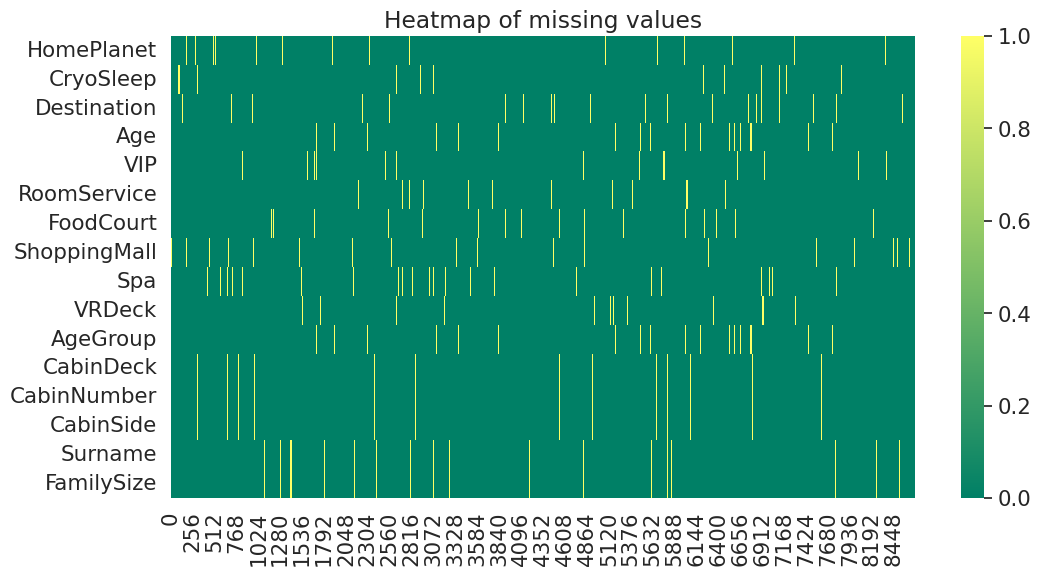

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(train[na_cols].isna().T, cmap="summer")
plt.title("Heatmap of missing values");

Missing values make up about 2% of the data, which is a relatively small amount. For the most part, they don't seem to be happening at the same time (except the features made from splitting Cabin and Name), but let's inspect closer.

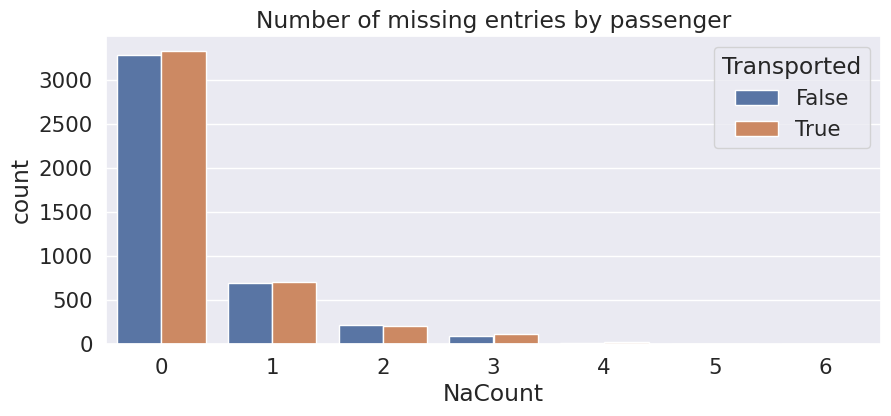

In [ ]:
train["NaCount"] = train.isna().sum(axis=1)
plt.figure(figsize=(10, 4))
sns.countplot(data=train, x="NaCount", hue="Transported")
plt.title("Number of missing entries by passenger")
train.pop("NaCount");

*Notes:*
* Missing values are independent of the target and for the most part are isolated. 
* Even though only 2% of the data is missing, about 25% of all passengers have at least 1 missing value.
* PassengerId is the only (original) feature to not have any missing values. 


*Insight:*
* Since most of the missing values are isolated it makes sense to try to fill these in as opposed to just dropping rows.
* If there is a relationship between PassengerId and other features we can fill missing values according to this column.

**Strategy**

we need to look for patterns within the missing data. The way to do this is by looking at the **joint distribution** of features, e.g. do passengers from the same group tend to come from the same family? There are obviously many combinations so we will just summarize the useful trends I and others have found.

### **HomePlanet**

**HomePlanet and Group**

Let's look at the joint distribution of HomePlanet and Group. We can see that passengers from the same group tend to come from the same HomePlanet. This is a useful pattern to exploit.

In [ ]:
GHp_gb = data.groupby(["Group", "HomePlanet"])["HomePlanet"].size().unstack().fillna(0)

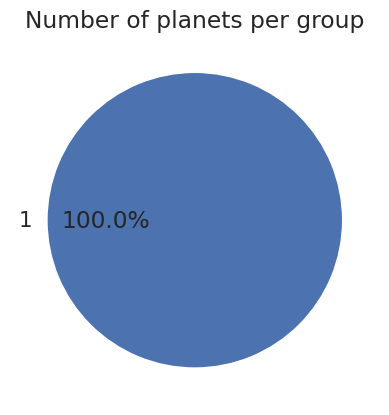

In [ ]:
t = "Number of planets per group"
d = {"kind": "pie", "title": t, "legend": False, "autopct": "%1.1f%%"}
(GHp_gb > 0).sum(axis=1).value_counts().plot(**d);

**Great!** This shows that everyone in the same group comes from the same home planet. So we can fill the missing HomePlanet values according to the group. (At least the ones where the group size is bigger than 1.)

In [ ]:
data["HomePlanet"] = impute_joint_dist("HomePlanet", "Group", GHp_gb)

HomePlanet, missing values before: 288
HomePlanet, missing values after: 157


We managed to fill 131 values with 100% confidence but we are not finished yet.

**HomePlanet and CabinDeck**

In [ ]:
CdHp_gb = (
    data.groupby(["CabinDeck", "HomePlanet"])["HomePlanet"].size().unstack().fillna(0)
)

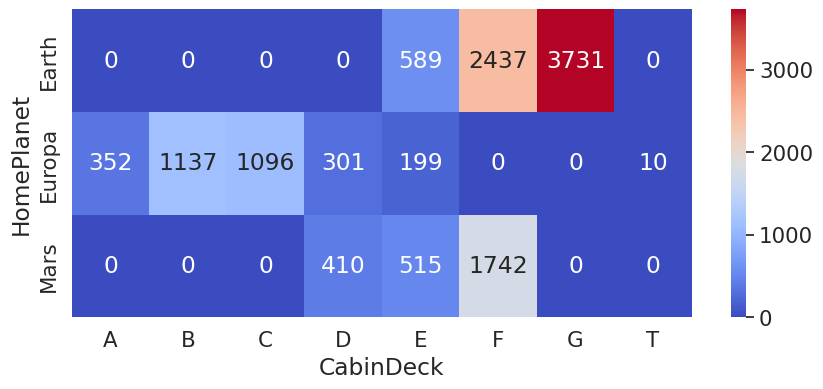

In [ ]:
plt.figure(figsize=(10, 4))
sns.heatmap(CdHp_gb.T, annot=True, fmt="g", cmap="coolwarm");

*Insight:*
* Passengers on decks A, B, C or T came from Europa.
* Passengers on deck G came from Earth.
* Passengers on decks D, E or F came from multiple planets.

In [ ]:
p("HomePlanet", "b")
Hp_isna = data["HomePlanet"].isna()
decks = ["A", "B", "C", "T"]
data.loc[Hp_isna & (data["CabinDeck"].isin(decks)), "HomePlanet"] = "Europa"
data.loc[Hp_isna & (data["CabinDeck"] == "G"), "HomePlanet"] = "Earth"
p("HomePlanet", "a")

HomePlanet, missing values before: 157
HomePlanet, missing values after: 94


**HomePlanet and Surname**

In [ ]:
SHp_gb = data.groupby(["Surname", "HomePlanet"])["HomePlanet"].size().unstack()

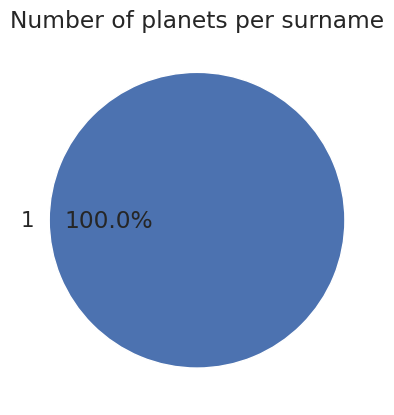

In [ ]:
t = "Number of planets per surname"
d = {"kind": "pie", "title": t, "legend": False, "autopct": "%1.1f%%"}
(SHp_gb > 0).sum(axis=1).value_counts().plot(**d);


**Fantastic!** Everyone with the same surname comes from the same home planet.

In [ ]:
data["HomePlanet"] = impute_joint_dist("HomePlanet", "Surname", SHp_gb)

HomePlanet, missing values before: 94
HomePlanet, missing values after: 10


Only 10 HomePlanet missing values left - let's look at them

In [ ]:
data[data["HomePlanet"].isna()][["PassengerId", "HomePlanet", "Destination"]]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


Everyone left is heading towards TRAPPIST-1e. So let's look at the joint distribution of HomePlanet and Destination.

**HomePlanet and Destination**

In [ ]:
HpD_gb = data.groupby(["HomePlanet", "Destination"])["Destination"].size().unstack()

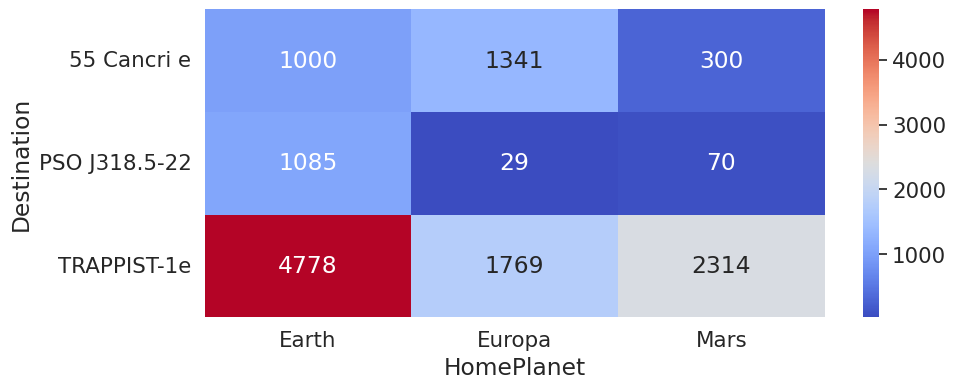

In [ ]:
plt.figure(figsize=(10, 4))
sns.heatmap(HpD_gb.T, annot=True, fmt="g", cmap="coolwarm");

Most people heading towards TRAPPIST-1e came from Earth so it makes sense to guess they came from there. But remember from earlier, no one on deck D came from Earth so we need to filter these out.

In [ ]:
p("HomePlanet", "b")
Hp_isna = data["HomePlanet"].isna()
data.loc[Hp_isna & ~(data["CabinDeck"] == "D"), "HomePlanet"] = "Earth"
data.loc[Hp_isna & (data["CabinDeck"] == "D"), "HomePlanet"] = "Mars"
p("HomePlanet", "a")

HomePlanet, missing values before: 10
HomePlanet, missing values after: 0


*Awesome!* We're done with HomePlanet.

### **Destination**

Since the majority (68%) of passengers are heading towards TRAPPIST-1e (see EDA section), we'll just impute this value (i.e. the mode). A better rule hasn't been found at this stage.

In [ ]:
p("Destination", "b")
data.loc[(data["Destination"].isna()), "Destination"] = "TRAPPIST-1e"
p("Destination", "a")

Destination, missing values before: 274
Destination, missing values after: 0


### **Surname/FamilySize**

**Surname and Group**

The reason we are filling missing surnames is because we will use surnames later to fill missing values of other features. It also means we can improve the accuracy of the family size feature.

In [ ]:
GS_gb = (
    data[data["GroupSize"] > 1]
    .groupby(["Group", "Surname"])["Surname"]
    .size()
    .unstack()
)

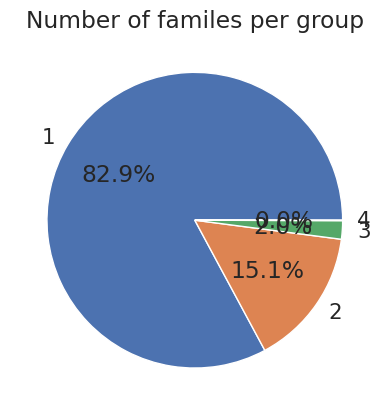

In [ ]:
t = "Number of familes per group"
d = {"kind": "pie", "title": t, "legend": False, "autopct": "%1.1f%%"}
(GS_gb > 0).sum(axis=1).value_counts().plot(**d);

The majority (83%) of groups contain only 1 family. So let's fill missing surnames according to the majority surname in that group.

In [ ]:
data["Surname"] = impute_joint_dist("Surname", "Group", GS_gb)

Surname, missing values before: 294
Surname, missing values after: 155


We don't have to get rid of all of these missing values because we will end up dropping the surname feature anyway. However, we can update the family size feature.

In [ ]:
p("FamilySize", "b")
surname_dict = data["Surname"].value_counts().to_dict()
data["FamilySize"] = data["Surname"].map(surname_dict).fillna(0)
p("FamilySize", "a")

FamilySize, missing values before: 294
FamilySize, missing values after: 0


FamilySize is done!

### **Cabin**

**CabinSide and Group**

In [ ]:
f_gb = lambda df, g1, g2: df.groupby([g1, g2])[g2].size().unstack()

GCd_gb = f_gb(data[data["GroupSize"] > 1], "Group", "CabinDeck")
GCn_gb = f_gb(data[data["GroupSize"] > 1], "Group", "CabinNumber")
GCs_gb = f_gb(data[data["GroupSize"] > 1], "Group", "CabinSide")

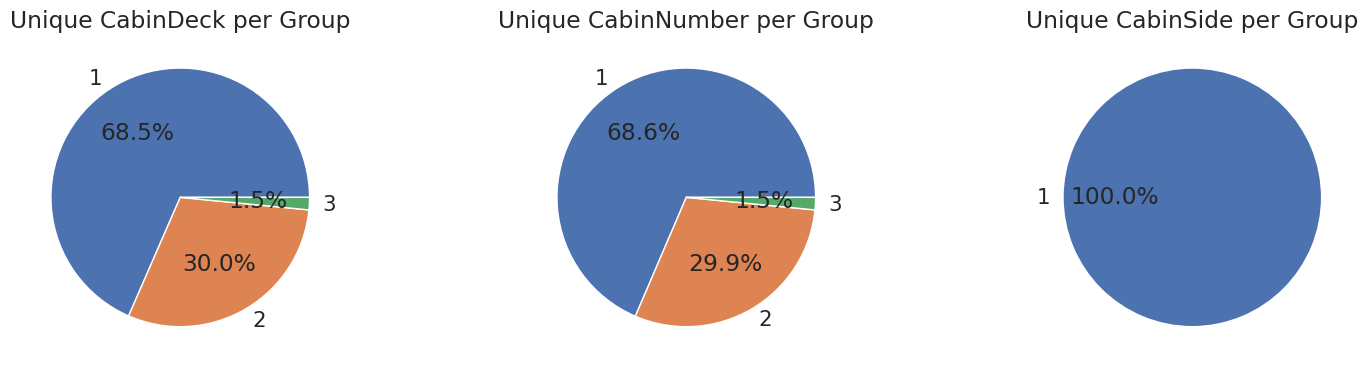

In [ ]:
fig = plt.figure(figsize=(16, 4))
for i, gb in enumerate([GCd_gb, GCn_gb, GCs_gb], 1):
    plt.subplot(1, 3, i)
    d = {"kind": "pie", "title": t, "legend": False, "autopct": "%1.1f%%"}
    (gb > 0).sum(axis=1).value_counts().plot(**d)
    plt.title(f"Unique {gb.columns.name} per Group")
fig.tight_layout()

**Another rule!** Everyone in the same group is also on the same cabin side. For cabin deck and cabin number there is also a fairly good (but not perfect) correlation with group.

In [ ]:
data["CabinSide"] = impute_joint_dist("CabinSide", "Group", GCs_gb)

CabinSide, missing values before: 299
CabinSide, missing values after: 162


**CabinSide and Surname**

lets explore the relationship between CabinSide and Surname.

In [ ]:
SCs_gb = f_gb(data[data["GroupSize"] > 1], "Surname", "CabinSide")

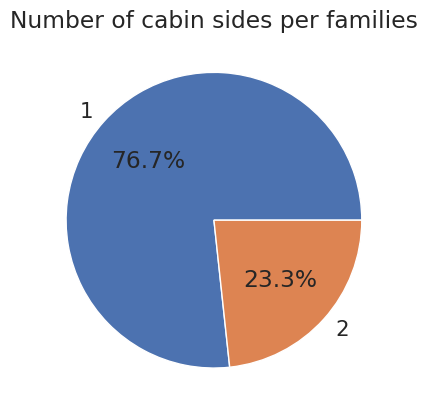

In [ ]:
t = "Number of cabin sides per families"
d = {"kind": "pie", "title": t, "legend": False, "autopct": "%1.1f%%"}
(SCs_gb > 0).sum(axis=1).value_counts().plot(**d);

This shows that families tend to be on the same cabin side, with almost 77% of families are entirely on the same side.

In [ ]:
data["CabinSide"] = impute_joint_dist("CabinSide", "Surname", SCs_gb)

CabinSide, missing values before: 162
CabinSide, missing values after: 66


The remaining missing values will be replaced with an outlier. This is because we really don't know which one of the two (balanced) sides we should assign.

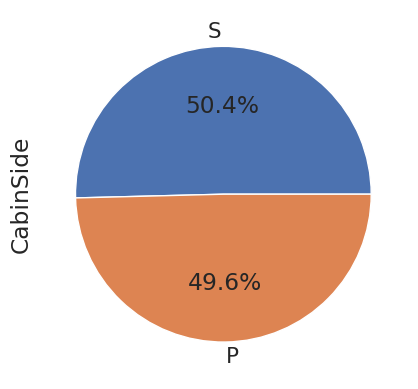

In [ ]:
data["CabinSide"].value_counts(normalize=True).plot(kind="pie", autopct="%1.1f%%");

In [ ]:
p("CabinSide", "b")
data.loc[data["CabinSide"].isna(), "CabinSide"] = "Z"
p("CabinSide", "a")

CabinSide, missing values before: 66
CabinSide, missing values after: 0


**CabinDeck**

Remember (from above) that groups tend to be on the same cabin deck. So lets fill the nan values accordingly.

In [ ]:
data["CabinDeck"] = impute_joint_dist("CabinDeck", "Group", GCd_gb)

CabinDeck, missing values before: 299
CabinDeck, missing values after: 162


Let's continue to explore the CabinDeck feature. We will create a joint distribution to look for significant patterns.

In [ ]:
data.groupby(["HomePlanet", "Destination", "Solo", "CabinDeck"])[
    "CabinDeck"
].size().unstack().fillna(0)

CabinDeck                          A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

CabinDeck                           G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

*Notes:*
* Passengers from Mars are most likely in deck F.
* Passengers from Europa are (more or less) most likely in deck C if travelling solo and deck B otherwise.
* Passengers from Earth are (more or less) most likely in deck G.

We will fill in missing values according to where the mode appears in these subgroups.

In [ ]:
data["CabinDeck"] = impute_transform("CabinDeck", ["HomePlanet", "Destination", "Solo"])

CabinDeck, missing values before: 162
CabinDeck, missing values after: 0


**CabinNumber and CabinDeck**

One interesting pattern that other kagglers have discovered is a linear relationship that appear from some of the features in the data. Let us take a look at this plotted:

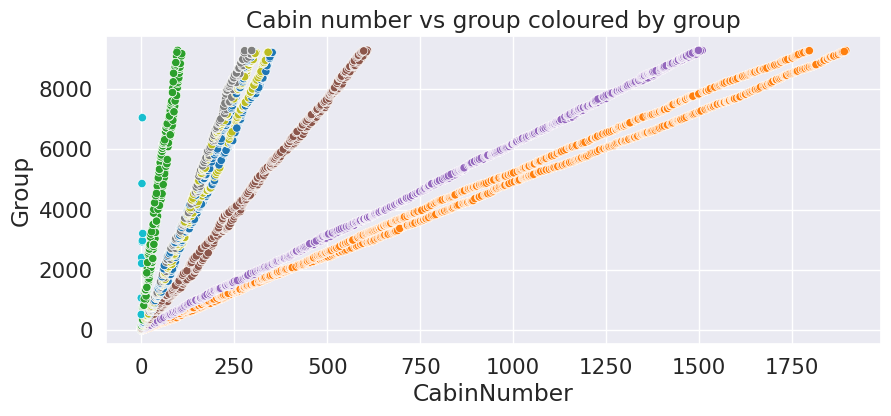

In [ ]:
plt.figure(figsize=(10, 4))
sns.scatterplot(
    x=data["CabinNumber"],
    y=data["Group"],
    c=data.loc[~data["CabinNumber"].isna(), "CabinDeck"].factorize()[0],
    cmap="tab10",
)
plt.title("Cabin number vs group coloured by group");

The CabinNumber and GroupNumber share a linear relationship on a deck by deck basis. We can therefore extrapolate the missing cabin numbers using linear regression on a deck by deck basis to get an approximate cabin number.

In [ ]:
p("CabinNumber", "b")

for deck in decklist[:-1]:
    Cn_na = data["CabinNumber"].isna()
    Cd_d = data["CabinDeck"] == deck

    X = data.loc[~Cn_na & Cd_d, "Group"].values.reshape(-1, 1)
    y_ = data.loc[~Cn_na & Cd_d, "CabinNumber"]
    X_test = data.loc[Cn_na & Cd_d, "Group"].values.reshape(-1, 1)

    model = LinearRegression()
    model.fit(X, y_)
    preds = model.predict(X_test)

    data.loc[Cn_na & Cd_d, "CabinNumber"] = preds.astype(int)

p("CabinNumber", "a")

CabinNumber, missing values before: 299
CabinNumber, missing values after: 0


Let's also update the cabin regions with the new data.

In [ ]:
region = pd.cut(data["CabinNumber"], cabin_bins, labels=range(1, 8))
data = data.drop([f"CabinRegion_{i}" for i in range(1, 8)], axis=1)
data = pd.concat([data, pd.get_dummies(region, prefix="CabinRegion")], axis=1)

### **VIP**

VIP is a highly unbalanced binary feature so we will just impute the mode.

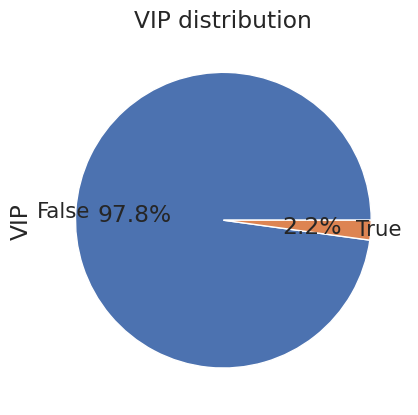

In [ ]:
data["VIP"].value_counts(normalize=True).plot(
    kind="pie", autopct="%1.1f%%", labeldistance=0.9
).set_title("VIP distribution");

In [ ]:
p("VIP", "b")
data.loc[data["VIP"].isna(), "VIP"] = False
p("VIP", "a")

VIP, missing values before: 296
VIP, missing values after: 0


### **Age**

Age varies across many features like HomePlanet, group size, expenditure and cabin deck, so we will impute missing values according to the median of these subgroups.

In [ ]:
data.groupby(["HomePlanet", "NoSpending", "Solo", "CabinDeck"])[
    "Age"
].median().unstack().fillna(0)

CabinDeck                      A     B     C     D     E     F     G     T
HomePlanet NoSpending Solo                                                
Earth      0          0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                      1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1          0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                      1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0          0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                      1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1          0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                      1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0          0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                      1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1          0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                      1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [ ]:
data["Age"] = impute_transform(
    "Age", ["HomePlanet", "NoSpending", "Solo", "CabinDeck"], "median"
)

Age, missing values before: 270
Age, missing values after: 0


Let's update the age_group feature using the new data.

In [ ]:
data["AgeGroup"] = pd.cut(data["Age"], age_bins, labels=age_titles)

### **CryoSleep**

The best way to predict if a passenger is in CryoSleep or not is to see if they spent anything.

In [ ]:
CsNp_gb = data.groupby(["CryoSleep", "NoSpending"]).size().unstack().fillna(0)

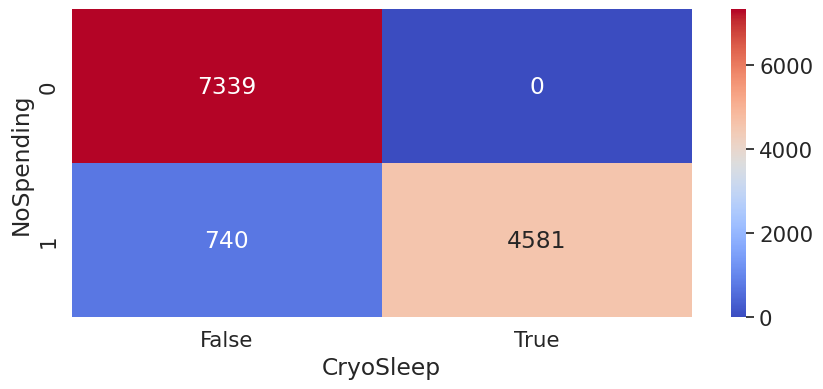

In [ ]:
plt.figure(figsize=(10, 4))
sns.heatmap(CsNp_gb.T, annot=True, fmt="g", cmap="coolwarm");

In [ ]:
data["CryoSleep"] = impute_transform("CryoSleep", ["NoSpending"])

CryoSleep, missing values before: 310
CryoSleep, missing values after: 0


We can also see that all passengers in CyroSleep have no spendings. This one makes a lot of sense. We don't expect people in CryoSleep to be able to spend anything, so we will fill the missing values for Expenditure with 0 for CryoSleep.

In [ ]:
print("Expenditure, missing values before:", data[exp_feats].isna().sum().sum())
for col in exp_feats:
    data.loc[(data[col].isna()) & (data["CryoSleep"] == True), col] = 0

print("Expenditure, missing values after:", data[exp_feats].isna().sum().sum())

Expenditure, missing values before: 1410
Expenditure, missing values after: 866


### **Expenditure**

Expenditure varies across many features but we will only impute missing values using HomePlanet, Solo and Age group to prevent overfitting. We will also use the mean instead of the median because a large proportion of passengers don't spend anything and median usually comes out as 0. Note how under 12's don't spend anything.

In [ ]:
data.groupby(["HomePlanet", "Solo", "AgeGroup"])["Expenditure"].mean().unstack()

AgeGroup         Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   724.902222   789.700555   841.093596   736.655773   
           1          0.0   693.014898   779.395942   795.420690   794.818627   
Europa     0          0.0  1153.160256  2652.013298  3534.668246  3975.774005   
           1          NaN     0.000000  2489.888889  3806.000000  3949.939929   
Mars       0          0.0  1176.839286  1161.808333  1247.098361  1143.671916   
           1          0.0  1687.261538  1075.341146  1107.122677  1110.392045   

AgeGroup             Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

In [ ]:
for col in exp_feats:
    data[col] = impute_transform(col, ["HomePlanet", "Solo", "AgeGroup"], "mean")

RoomService, missing values before: 170
RoomService, missing values after: 0
FoodCourt, missing values before: 179
FoodCourt, missing values after: 0
ShoppingMall, missing values before: 172
ShoppingMall, missing values after: 0
Spa, missing values before: 173
Spa, missing values after: 0
VRDeck, missing values before: 172
VRDeck, missing values after: 0


Finally, we can update the expenditure and NoSpending features with these new data points. We also drop Surname due to high cardinality and put FamilySize last like in the original notebook.

In [ ]:
data["Expenditure"] = data[exp_feats].sum(axis=1)
data["NoSpending"] = (data["Expenditure"] == 0).astype(int)

data["FamilySize"] = data.pop("FamilySize")
data.pop("Surname");

***All done!***

In [ ]:
data.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
AgeGroup         0
Expenditure      0
NoSpending       0
Group            0
GroupSize        0
Solo             0
CabinDeck        0
CabinNumber      0
CabinSide        0
CabinRegion_1    0
CabinRegion_2    0
CabinRegion_3    0
CabinRegion_4    0
CabinRegion_5    0
CabinRegion_6    0
CabinRegion_7    0
FamilySize       0
dtype: int64

No missing values left! It was a lot of effort but it should improve the accuracy of our models.

## ***Preprocessing***

Split data back into train and test sets and drop unwanted features

In [ ]:
X = data[data["PassengerId"].isin(train["PassengerId"].values)].copy()
X_test = data[data["PassengerId"].isin(test["PassengerId"].values)].copy()

drop_cols = ["PassengerId", "Group", "GroupSize", "AgeGroup", "CabinNumber"]
X = X.drop(drop_cols, axis=1)
X_test = X_test.drop(drop_cols, axis=1)

**Log transform**

The logarithm transform is used to decrease skew in distributions, especially with large outliers. It can make it easier for algorithms to 'learn' the correct relationships. We will apply it to the expenditure features as these are heavily skewed by outliers.

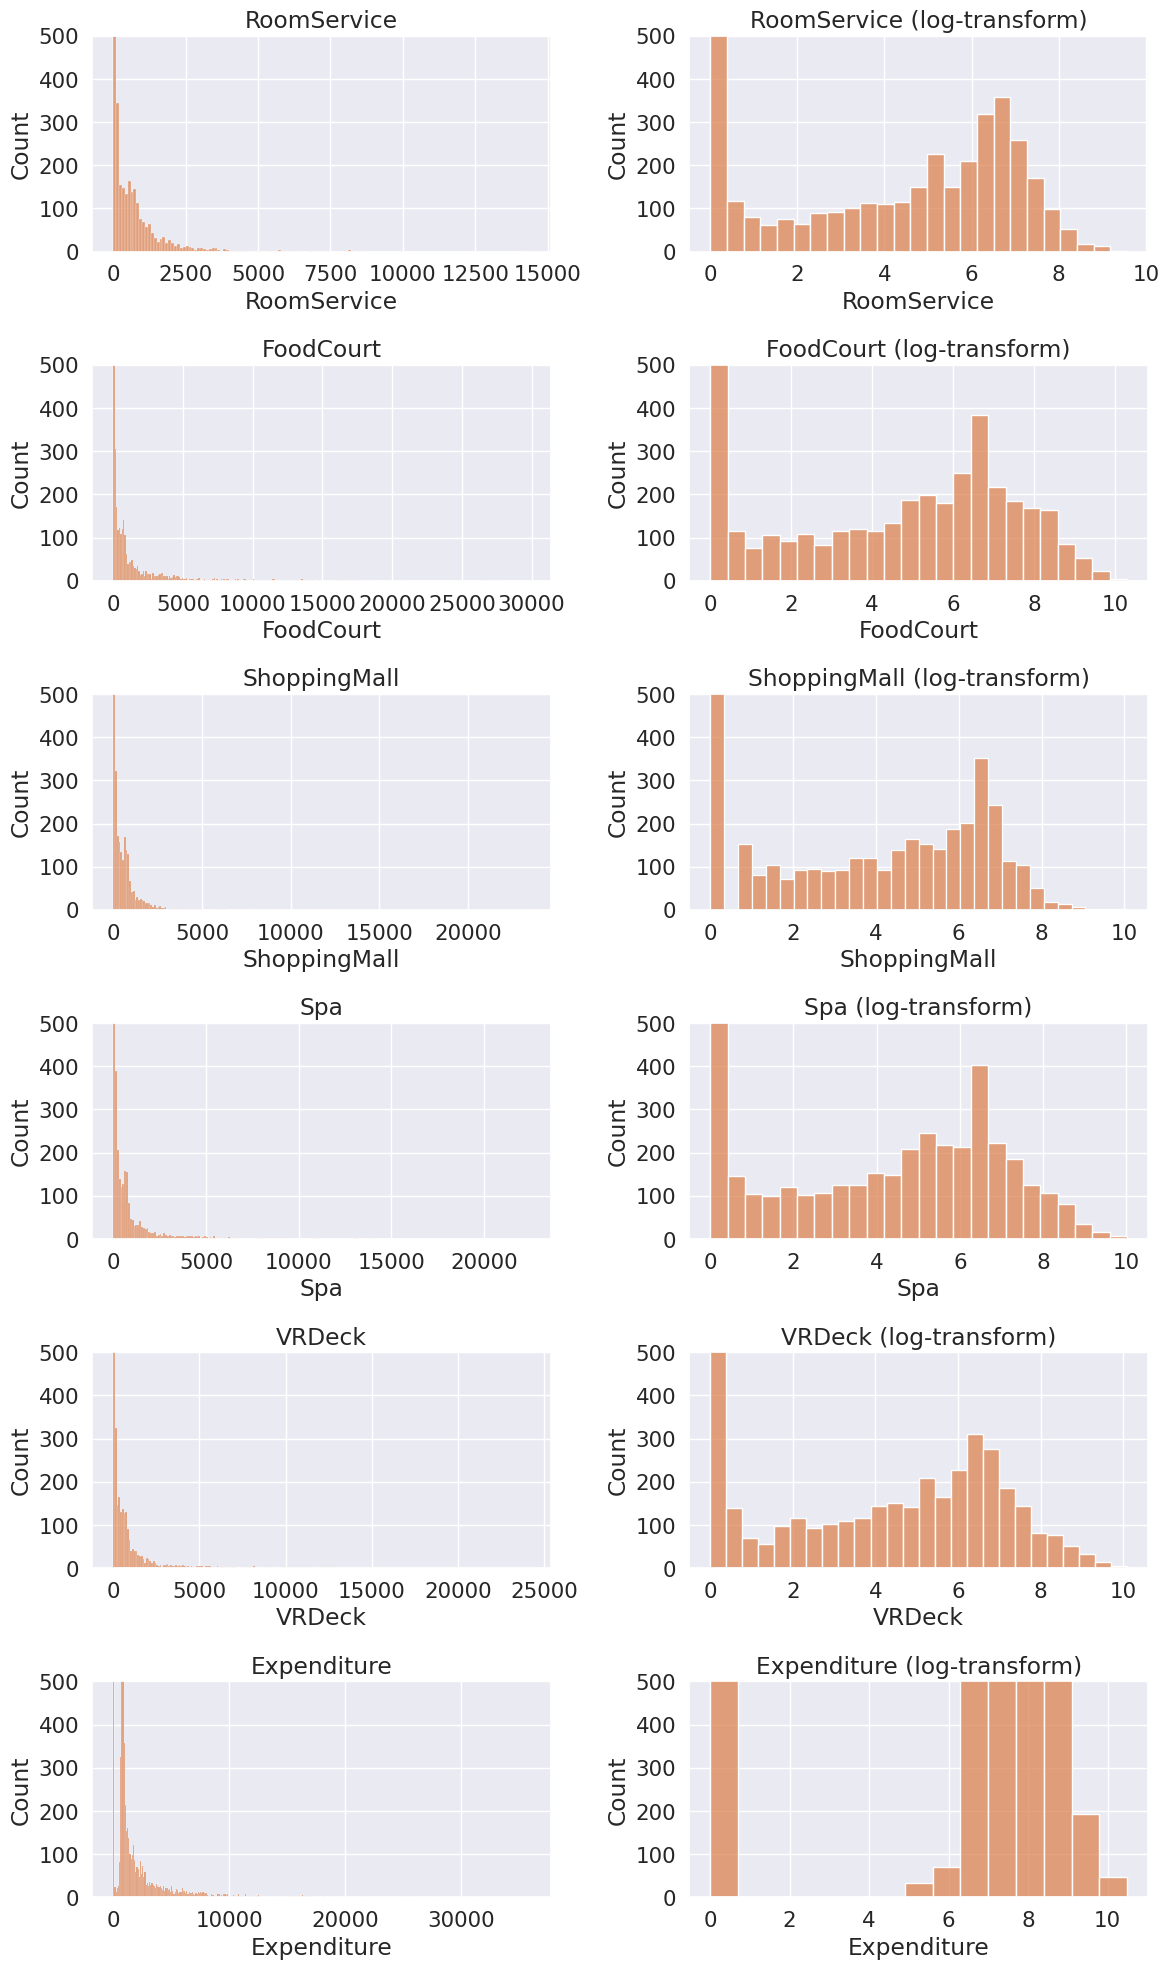

In [ ]:
fig = plt.figure(figsize=(12, 20))
for i, col in enumerate(exp_feats + ["Expenditure"]):
    plt.subplot(6, 2, 2 * i + 1)
    sns.histplot(X[col], color="C1", binwidth=100)
    plt.ylim([0, 500])
    plt.title(f"{col}")

    plt.subplot(6, 2, 2 * i + 2)
    sns.histplot(np.log(1 + X[col]), color="C1")
    plt.ylim([0, 500])
    plt.title(f"{col} (log-transform)")

fig.tight_layout()
plt.show()

In [ ]:
for col in exp_feats + ["Expenditure"]:
    X[col] = np.log(1 + X[col])
    X_test[col] = np.log(1 + X_test[col])

**Encoding and scaling**

We use a pipeline to encode and scale the data. We will use a OneHotEncoder for categorical features and a StandardScaler for numerical features. We will also use a ColumnTransformer to apply the pipeline to the correct columns.

In [ ]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

cat_par = {"drop": "if_binary", "handle_unknown": "ignore", "sparse": False}

ct = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(**cat_par), categorical_cols),
    ],
)

X = ct.fit_transform(X)
X_test = ct.transform(X_test)

print("Training set shape:", X.shape)

Training set shape: (8693, 36)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, train_size=0.8, test_size=0.2, random_state=0
)

## ***Modeling***

To briefly mention the algorithms we will use,

**Light Gradient Boosting Machine (LGBM):** LGBM works essentially the same as XGBoost but with a lighter boosting technique. It usually produces similar results to XGBoost but is significantly faster.

**Categorical Boosting (CatBoost):** CatBoost is an open source algorithm based on gradient boosted decision trees. It supports numerical, categorical and text features. It works well with heterogeneous data and even relatively small data. Informally, it tries to take the best of both worlds from XGBoost and LGBM.


In [ ]:
load_classifiers = {
    "LGBM": (LGBMClassifier, {"random_state": 0}),
    "CatBoost": (CatBoostClassifier, {"random_state": 0, "verbose": False}),
}

params = {
    "n_estimators": (50, 100, 150, 200),
    "max_depth": (4, 8, 12),
    "learning_rate": (0.05, 0.1, 0.15),
}

**Train and evaluate models**

Train models with grid search (but no cross validation so it doesn't take too long) to get a rough idea of which are the best models for this dataset.

In [ ]:
final_params = {}
for name, (classifier, par) in load_classifiers.items():
    start = time()

    clf = GridSearchCV(
        estimator=classifier(**par),
        param_grid=params,
        n_jobs=-1,
        cv=None,
    )

    clf.fit(X_train, y_train)
    final_params[name] = clf.best_params_

    print("Model:", name)
    print(f"Training time (mins): {np.round((time() - start) / 60, 2)}")
    print(f"Training score: {clf.score(X_valid, y_valid):.4}\n")

Model: LGBM
Training time (mins): 0.08
Training score: 0.7976

Model: CatBoost
Training time (mins): 3.42
Training score: 0.8074



Best parameters:

In [ ]:
display(pd.DataFrame(final_params).T)

,learning_rate,max_depth,n_estimators
LGBM,0.05,8.0,100.0
CatBoost,0.15,4.0,100.0


**Cross validation and ensembling predictions**

We can finally train our best model on the whole training set using cross validation and ensembling predictions together to produce the most confident predictions.

Predictions are ensembled together using soft voting. This averages the predicted probabilies to produce the most confident predictions.

In [ ]:
cls_val, par_val = load_classifiers.values(), final_params.values()
classifiers = [model(**p1, **p2) for (model, p1), p2 in zip(cls_val, par_val)]

folds = 10
preds = np.zeros(len(X_test))

for clf, name in zip(classifiers, final_params.keys()):
    start = time()

    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)

    score = 0
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        clf.fit(X_train, y_train)

        preds += clf.predict_proba(X_test)[:, 1]
        score += clf.score(X_valid, y_valid)

    score = score / folds

    print(f"Model: {name}\nAverage validation accuracy: {np.round(100 * score, 3)}")
    print(f"Training time (mins): {np.round((time() - start) / 60, 2)}\n")


preds = preds / (folds * len(classifiers))

Model: LGBM
Average validation accuracy: 81.019
Training time (mins): 0.04

Model: CatBoost
Average validation accuracy: 81.169
Training time (mins): 0.05



## ***Submission***

Let's look at the distribution of the predicted probabilities.

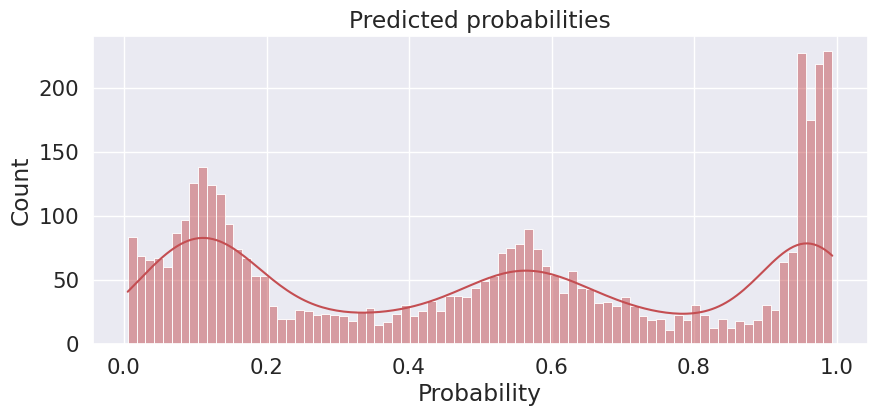

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(preds, bins=80, kde=True, color="C3")
plt.title("Predicted probabilities")
plt.xlabel("Probability");

It is interesting to see that the models are either very confident or very unconfident but not much in between.

**Post processing**

Finally, we need to convert each predicted probability into one of the two classes (transported or not). The simplest way is to round each probability to the nearest integer (0 for False or 1 for True). However, assuming the train and test sets have similar distributions, we can tune the classification threshold to obtain a similar proportion of transported/not transported in our predictions as in the train set. Remember that the proportion of transported passengers in the train set was 50.4%.

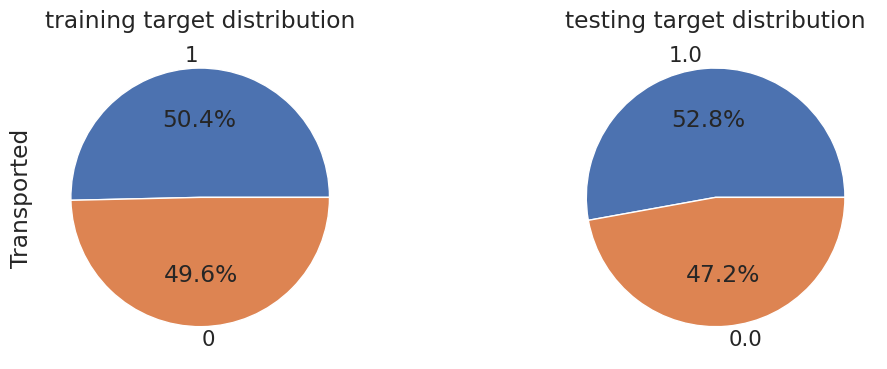

In [ ]:
pred_round = pd.Series(np.round(preds))

fig = plt.figure(figsize=(16, 4))
for i, p in enumerate((y, pred_round)):
    plt.subplot(1, 3, i + 1)
    p.value_counts().plot.pie(autopct="%1.1f%%").set_title(
        f"{'testing' if i else 'training'} target distribution"
    )
fig.tight_layout()

Our models seem to (potentially) overestimate the number of transported passengers in the test set. Let's try to bring that proportion down a bit. 

In [ ]:
def tune_preds(preds, prop):
    thresh, res = 0.5, -1

    prop = np.round(prop, 3)
    while res != prop:
        res = round((preds >= thresh).sum() / len(preds), 3)
        thresh += 0.001 if res > prop else -0.001 if res < prop else 0
    return (preds >= thresh).astype(int)


prop = 0.519  # Experiment with this value
preds_tuned = tune_preds(preds, prop)

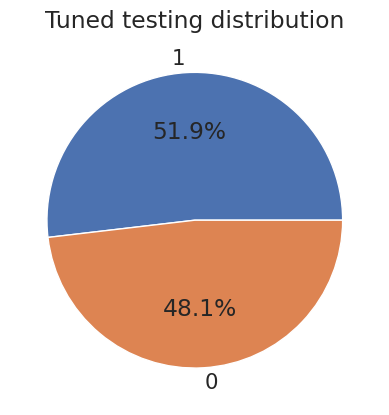

In [ ]:
pd.Series(preds_tuned).value_counts().plot.pie(autopct="%1.1f%%").set_title(
    "Tuned testing distribution"
);

**Submit predictions**

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub["Transported"] = preds_tuned
sub = sub.replace({0: False, 1: True})

sub.to_csv("submission.csv", index=False)

## ***THE END***

Wow! That was a lot of work, but thankfully we made it all the way to the end. We also scored the exact same result as the original notebook, which was my goal. This placed us in position 155 out of more than 2000 submissions in this ongoing Kaggle competition.


My next step will be to try and improve this score by trying out different models and doing hyperparameter optimization, so stay tuned for that!


<p align="center">
  <img src="kaggle_score2.png" alt="Kaggle_score">
</p>

Thank you for reading! I hope you enjoyed this notebook. If you have any questions or suggestions, please leave a comment below. I would love to hear your thoughts.

<div style="text-align: center"></div>




<p align="center">
  <img src="mid_tran.png" alt="Titanic_2"><br>
  Image by Midjourney, prompt by me
</p>
